In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class DiscreteAssetAllocationEnv:
    """Environment for discrete asset allocation problem in reinforcement learning.

    This class simulates a financial environment where an agent decides how to allocate
    wealth between a risk-free asset and a risky asset over a fixed number of time steps.
    The goal is to maximize utility based on wealth at the final step.

    Attributes:
        max_steps (int): Maximum number of time steps in an episode.
        risk_free_rate (float): Return rate of the risk-free asset per step.
        risky_up_prob (float): Probability of the risky asset increasing in value.
        risky_up_rate (float): Return rate of the risky asset when it increases.
        risky_down_rate (float): Return rate of the risky asset when it decreases.
        risk_aversion (float): Risk aversion parameter for utility calculation.
        _t (int): Current time step.
        _wealth (float): Current wealth of the agent.
        _action_space (np.ndarray): Array of possible action indices.
        _action_to_allocations (np.ndarray): Array mapping actions to allocation fractions.

    """
    def __init__(self,
                 max_steps=10,
                 risk_free_rate=0.005,
                 risky_up_prob=1.0,
                 risky_up_rate=0.03,
                 risky_down_rate=0.03,
                 risk_aversion=1.0,
                 action_count=2):
        """Initialize the discrete asset allocation environment.

        Args:
            max_steps (int, optional): Maximum number of time steps. Defaults to 10.
            risk_free_rate (float, optional): Risk-free return rate. Defaults to 0.005.
            risky_up_prob (float, optional): Probability of risky asset increase. Defaults to 1.0.
            risky_up_rate (float, optional): Return rate on risky asset increase. Defaults to 0.03.
            risky_down_rate (float, optional): Return rate on risky asset decrease. Defaults to 0.03.
            risk_aversion (float, optional): Risk aversion coefficient. Defaults to 1.0.
            action_count (int, optional): Number of discrete actions. Defaults to 2.
        """
        self.max_steps = max_steps
        self.risk_free_rate = risk_free_rate
        self.risky_up_prob = risky_up_prob
        self.risky_up_rate = risky_up_rate
        self.risky_down_rate = risky_down_rate
        self.risk_aversion = risk_aversion

        # Define agent state of the environment
        self._t = 0
        self._wealth = np.random.normal(1, 0.2)

        # Define the action spaces
        self._action_space = np.arange(action_count)
        self._action_to_allocations = np.linspace(0, 1, action_count)

    def _state(self):
        """Return the current state of the environment."""
        return self.state(self._t, self._wealth)

    def state(self, t, wealth):
        """Create a state dictionary from time and wealth.

        Args:
            t (int): Current time step.
            wealth (float): Current wealth.

        Returns:
            dict: State dictionary with 't' and 'wealth' keys.
        """
        return {"t": t, "wealth": wealth}

    def _utility(self, wealth):
        """Calculate utility based on wealth and risk aversion.

        Args:
            wealth (float): Current wealth.

        Returns:
            float: Utility value.
        """
        return (1 - np.exp(-self.risk_aversion * wealth)) / self.risk_aversion

    def action_space(self):
        """Return the action space.

        Returns:
            np.ndarray: Array of possible action indices.
        """
        return self._action_space

    def allocation(self, action):
        """Map an action to an allocation fraction.

        Args:
            action (int): Action index.

        Returns:
            float: Fraction of wealth to allocate to the risky asset.
        """
        return self._action_to_allocations[action]

    def reset(self):
        """Reset the environment to initial state.

        Returns:
            dict: Initial state dictionary.
        """
        self._t = 0
        self._wealth = np.random.normal(1, 0.2)
        return self._state()

    def step(self, action):
        """Execute one time step in the environment.

        Args:
            action (int): Action index chosen by the agent.

        Returns:
            tuple: (next_state, reward, is_last_step)
                - next_state (dict): Next state after the action.
                - reward (float): Reward received (utility at final step, else 0).
                - is_last_step (bool): Whether this is the final step.
        """
        allocation = self.allocation(action)
        is_last_step = self._t == self.max_steps - 1
        risky_asset_return = self.risky_up_rate if np.random.rand() < self.risky_up_prob else self.risky_down_rate
        next_wealth = self._wealth * (allocation * (1 + risky_asset_return) + (1 - allocation) * (1 + self.risk_free_rate))
        reward = self._utility(next_wealth) if is_last_step else 0

        self._t = self._t + 1
        self._wealth = next_wealth
        state = self._state()

        return state, reward, is_last_step

In [3]:
class DiscreteAssetAllocationAgent:
    """Agent for solving the discrete asset allocation problem using Q-learning.

    This class implements a reinforcement learning agent that uses function approximation
    with linear features to learn an optimal policy for allocating wealth between a
    risk-free and risky asset.

    Attributes:
        env (DiscreteAssetAllocationEnv): Environment instance for training.
        epsilon_start (float): Initial exploration probability.
        epsilon_end (float): Minimum exploration probability.
        epsilon_decay (float): Decay rate for epsilon.
        learning_rate_start (float): Initial learning rate.
        learning_rate_decay (float): Decay rate for learning rate.
        discount_factor (float): Discount factor for future rewards.
        epsilon (float): Current exploration probability.
        learning_rate (float): Current learning rate.
        thetas (list): List of weight vectors for Q-value approximation per time step.
        episode (int): Current episode number.
        training_error (list): List of TD errors during training.
        cumulative_rewards (float): Cumulative reward in current episode.
        cumulative_rewards_per_episode (list): Cumulative rewards per episode.
    """

    def __init__(self,
                 env,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay,
                 learning_rate_start,
                 learning_rate_decay,
                 discount_factor):
        """Initialize the discrete asset allocation agent.

        Args:
            env (DiscreteAssetAllocationEnv): Environment to interact with.
            epsilon_start (float): Starting value for epsilon (exploration).
            epsilon_end (float): Minimum value for epsilon.
            epsilon_decay (float): Decay rate for epsilon per episode.
            learning_rate_start (float): Starting learning rate.
            learning_rate_decay (float): Decay rate for learning rate per episode.
            discount_factor (float): Discount factor for future rewards.
        """

        # Environment for training
        self.env = env

        # Hyperparameters
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.learning_rate_start = learning_rate_start
        self.learning_rate_decay = learning_rate_decay
        self.discount_factor = discount_factor
        self.epsilon = self.epsilon_start
        self.learning_rate = self.learning_rate_start

        # Function approximation: Initialize weights
        self.thetas = [np.random.rand(5) * 0.01 for _ in range(self.env.max_steps)]

        # Training history and statistics
        self.episode = 0
        self.training_error = []
        self.cumulative_rewards = 0
        self.cumulative_rewards_per_episode = []

    def phi(self, state, action):
        """Compute feature vector for a state-action pair.

        Args:
            state (dict): Current state with 't' and 'wealth'.
            action (int): Action index.

        Returns:
            np.ndarray: Feature vector [1, wealth, wealth^2, allocation, wealth*allocation].
        """
        wealth = state["wealth"]
        allocation = self.env.allocation(action)
        return np.array([1.0, wealth, wealth**2, allocation, wealth * allocation])

    def q_value(self, state, action):
        """Compute Q-value for a state-action pair.

        Args:
            state (dict): Current state.
            action (int): Action index.

        Returns:
            float: Estimated Q-value.
        """
        features = self.phi(state, action)
        theta = self.thetas[state["t"]]
        return np.dot(theta, features)

    def optimal_action(self, state):
        """Determine the optimal action for a given state.

        Args:
            state (dict): Current state.

        Returns:
            int: Action index with the highest Q-value.
        """
        return int(np.argmax([self.q_value(state, a) for a in env.action_space()]))

    def get_action(self, state):
        """Choose an action using epsilon-greedy policy.

        Args:
            state (dict): Current state.

        Returns:
            int: Chosen action index.
        """
        if np.random.rand() < self.epsilon:  # exploration
            return np.random.choice(self.env.action_space())
        else:  # exploitation
            return self.optimal_action(state)

    def update(self, state, action, reward, is_last_step, next_state):
        """Update Q-value weights using TD learning.

        Args:
            state (dict): Current state.
            action (int): Action taken.
            reward (float): Reward received.
            is_last_step (bool): Whether this is the final step.
            next_state (dict): Next state after action.
        """
        q_value = self.q_value(state, action)

        # derive the TD error
        if is_last_step:
            q_next = 0
        else:
            q_next = np.max(np.array([self.q_value(next_state, a) for a in self.env.action_space()]))
        td_error = reward + self.discount_factor * q_next - q_value

        # update the estimate of the Q-value function by the TD error and the learning rate
        new_thetas = [ self.thetas[i] for i in range(len(self.thetas)) ]
        new_thetas[state["t"]] = self.thetas[state["t"]] + self.learning_rate * td_error * self.phi(state, action)
        self.thetas = new_thetas

        # update the training statistics
        self.training_error.append(td_error)
        self.cumulative_rewards += reward
        if is_last_step:
            self.episode += 1
            self.cumulative_rewards_per_episode.append(self.cumulative_rewards)
            self.cumulative_rewards = 0

    def decay_epsilon(self):
        """Decay the exploration probability epsilon."""
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(-self.epsilon_decay * self.episode)

    def decay_learning_rate(self):
        """Decay the learning rate."""
        self.learning_rate = self.learning_rate_start / (1 + self.learning_rate_decay * self.episode)

In [4]:
def training(env, agent, num_episodes):
    """Train the agent in the environment over a specified number of episodes.

    Args:
        env (DiscreteAssetAllocationEnv): Environment instance.
        agent (DiscreteAssetAllocationAgent): Agent instance to train.
        num_episodes (int): Number of episodes to train for.
    """
    for _ in tqdm(range(num_episodes)):
        state = env.reset()

        # play one episode
        is_last_step = False
        while not is_last_step:
            # get the next action based on the current state
            action = agent.get_action(state)
            # derive the next state and the reward based on the action
            next_state, reward, is_last_step = env.step(action)
            # update the Q-value function
            agent.update(state, action, reward, is_last_step, next_state)
            # move to the next state
            state = next_state

        agent.decay_epsilon()
        agent.decay_learning_rate()

In [5]:
def visualize_training_result(env, agent):
    # q-value convergence
    plt.figure(figsize=(10, 5))
    plt.plot(np.convolve(np.abs(agent.training_error), np.ones(10000)/10000, mode='valid'), label='Moving Avg Delta (window=10000)', color="blue")
    plt.xlabel("Episode")
    plt.ylabel("Max Q-Value Change")
    plt.title("Convergence of Q-Learning (T=10)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # cumulative reward per episode
    plt.figure(figsize=(10, 6))
    plt.plot(np.convolve(agent.cumulative_rewards_per_episode, np.ones(10000)/10000, mode='valid'), label='Moving Avg Reward')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Per Episode')
    plt.grid(True)
    plt.legend()
    plt.show()

    # policy heatmap
    wealth_grid = np.linspace(0.5, 1.5, 50)
    policy_grid = np.zeros((env.max_steps, len(wealth_grid)))
    for t in range(env.max_steps):
        for i, w in enumerate(wealth_grid):
            policy_grid[t, i] = env.allocation(agent.optimal_action(env.state(t, w)))
    plt.imshow(policy_grid, aspect='auto', extent=[0.5, 1.5, 0, env.max_steps-1], cmap='viridis', vmin=0, vmax=1)
    plt.xlabel('Wealth')
    plt.ylabel('Timestep')
    plt.title('Policy Heatmap (0 = Risk-Free, 1 = Risky)')
    plt.colorbar()
    plt.show()

    # Optimal policy for all time steps
    fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
    fig.suptitle("Optimal Policy for all time steps (t=1 to t=10)", fontsize=16)

    axes = axes.flatten()

    wealth = np.linspace(0.5, 1.5, 100)
    # Plot optimal policy for each t
    for t in range(env.max_steps):
        optimal_fraction = [env.allocation(agent.optimal_action(env.state(t, w))) for w in wealth]
        axes[t].plot(wealth, optimal_fraction, linewidth=1.5)
        axes[t].set_title(f"t={t+1}")
        axes[t].set_ylim(-0.1, 1.1)
        axes[t].grid(True)

    # Set common labels
    for ax in axes:
        ax.set_xlabel("Wealth")
        ax.set_ylabel("Optimal Fraction")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

### Experiment 1
The optimal strategy is to invest all in risky asset

100%|██████████| 1000000/1000000 [05:09<00:00, 3229.66it/s]


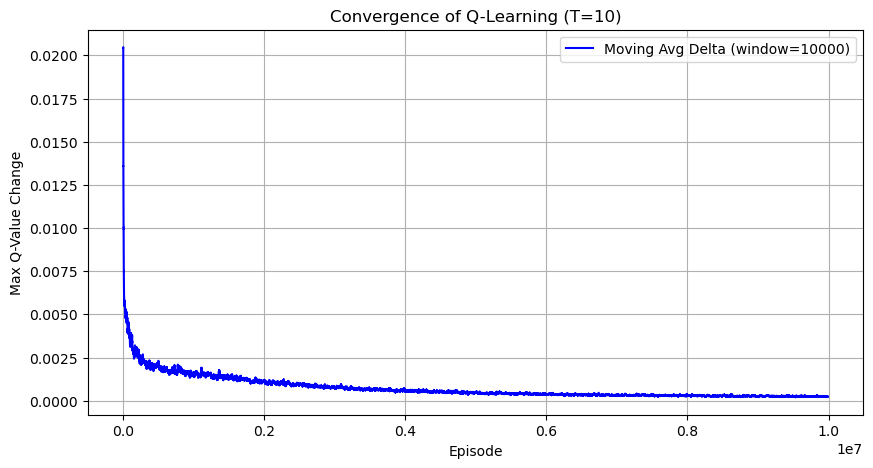

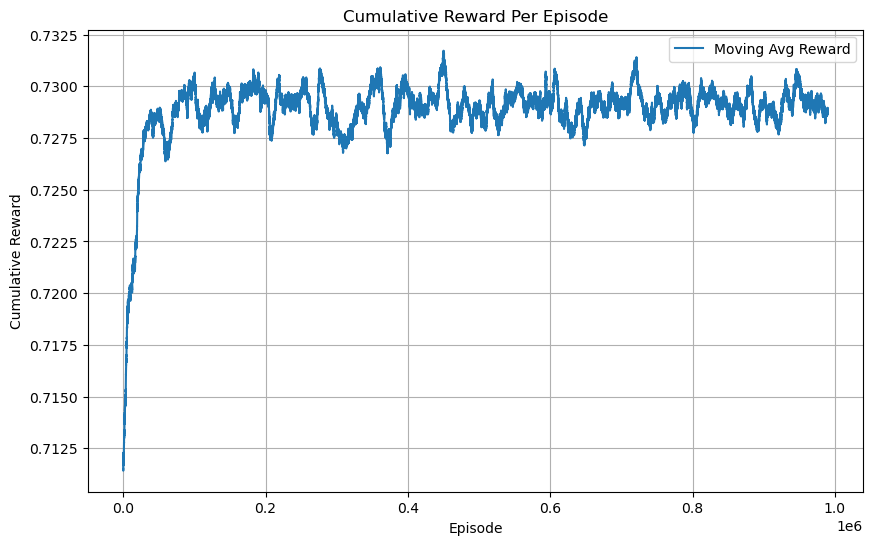

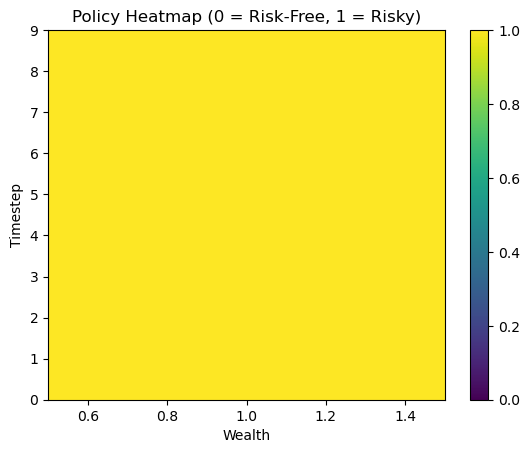

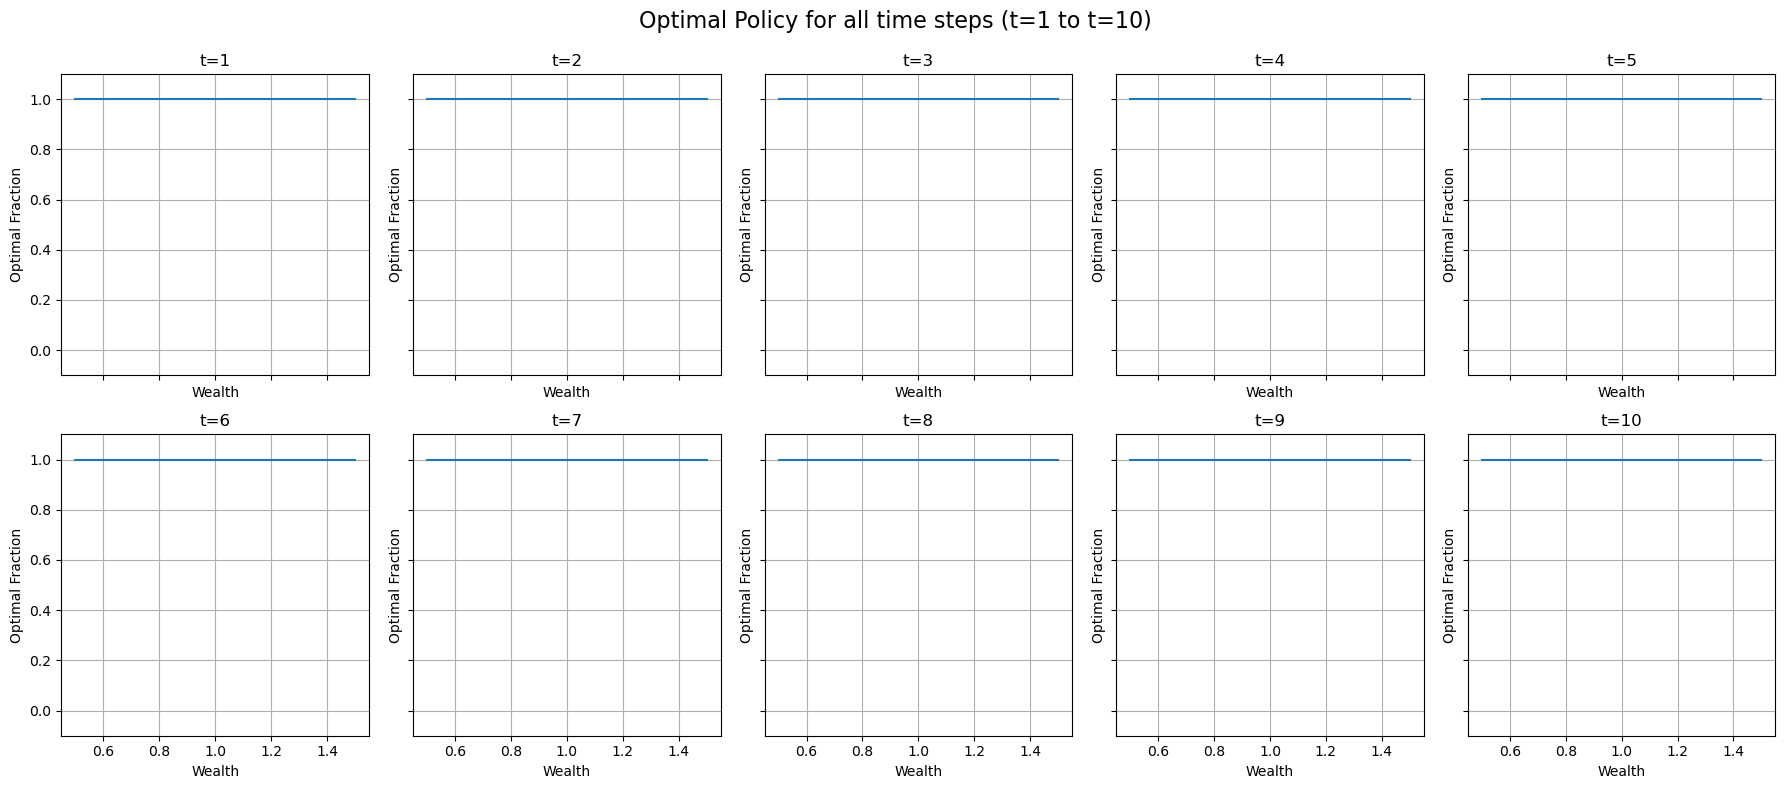

In [6]:
num_episodes = 1000000
env = DiscreteAssetAllocationEnv(
    max_steps=10,
    risk_free_rate=0.005,
    risky_up_prob=1.0,
    risky_up_rate=0.03,
    risky_down_rate=0.00,
    risk_aversion=1.0,
    action_count=10
)

agent = DiscreteAssetAllocationAgent(
    env=env,
    epsilon_start=0.5,
    epsilon_end=0.01,
    epsilon_decay=1 / (num_episodes / 100),
    learning_rate_start=0.1,
    learning_rate_decay=1 / (num_episodes / 10),
    discount_factor=1.0
)

training(env, agent, num_episodes)
visualize_training_result(env, agent)

### Experiment 2
The optimal strategy is to invest all in risk-free asset

100%|██████████| 1000000/1000000 [04:59<00:00, 3341.32it/s]


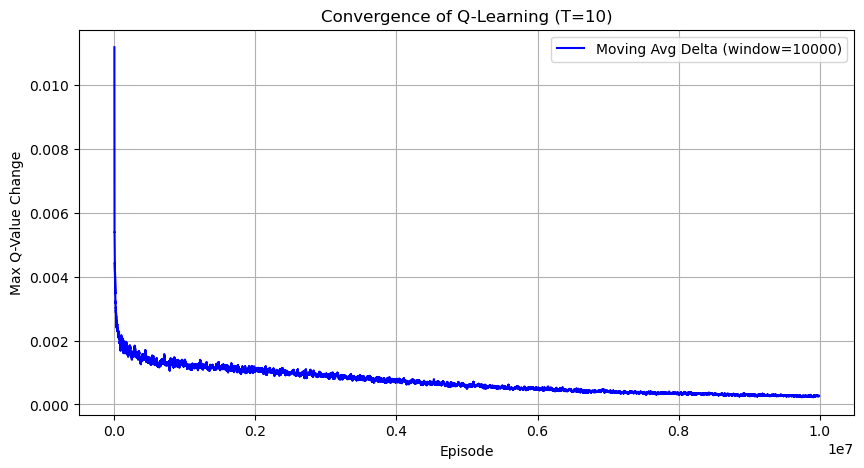

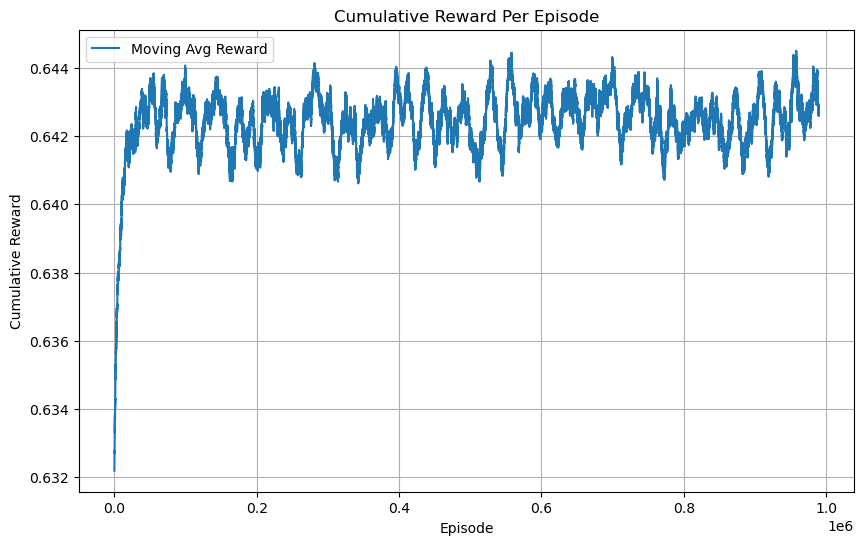

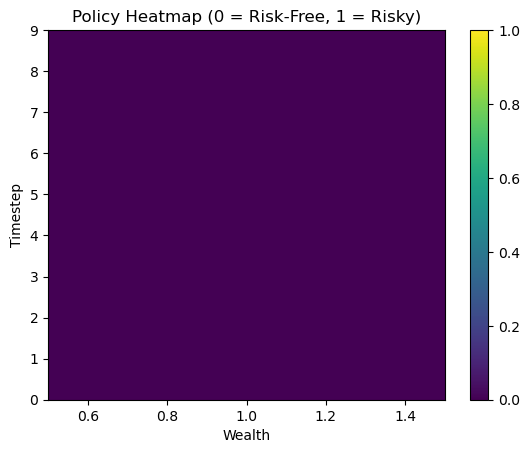

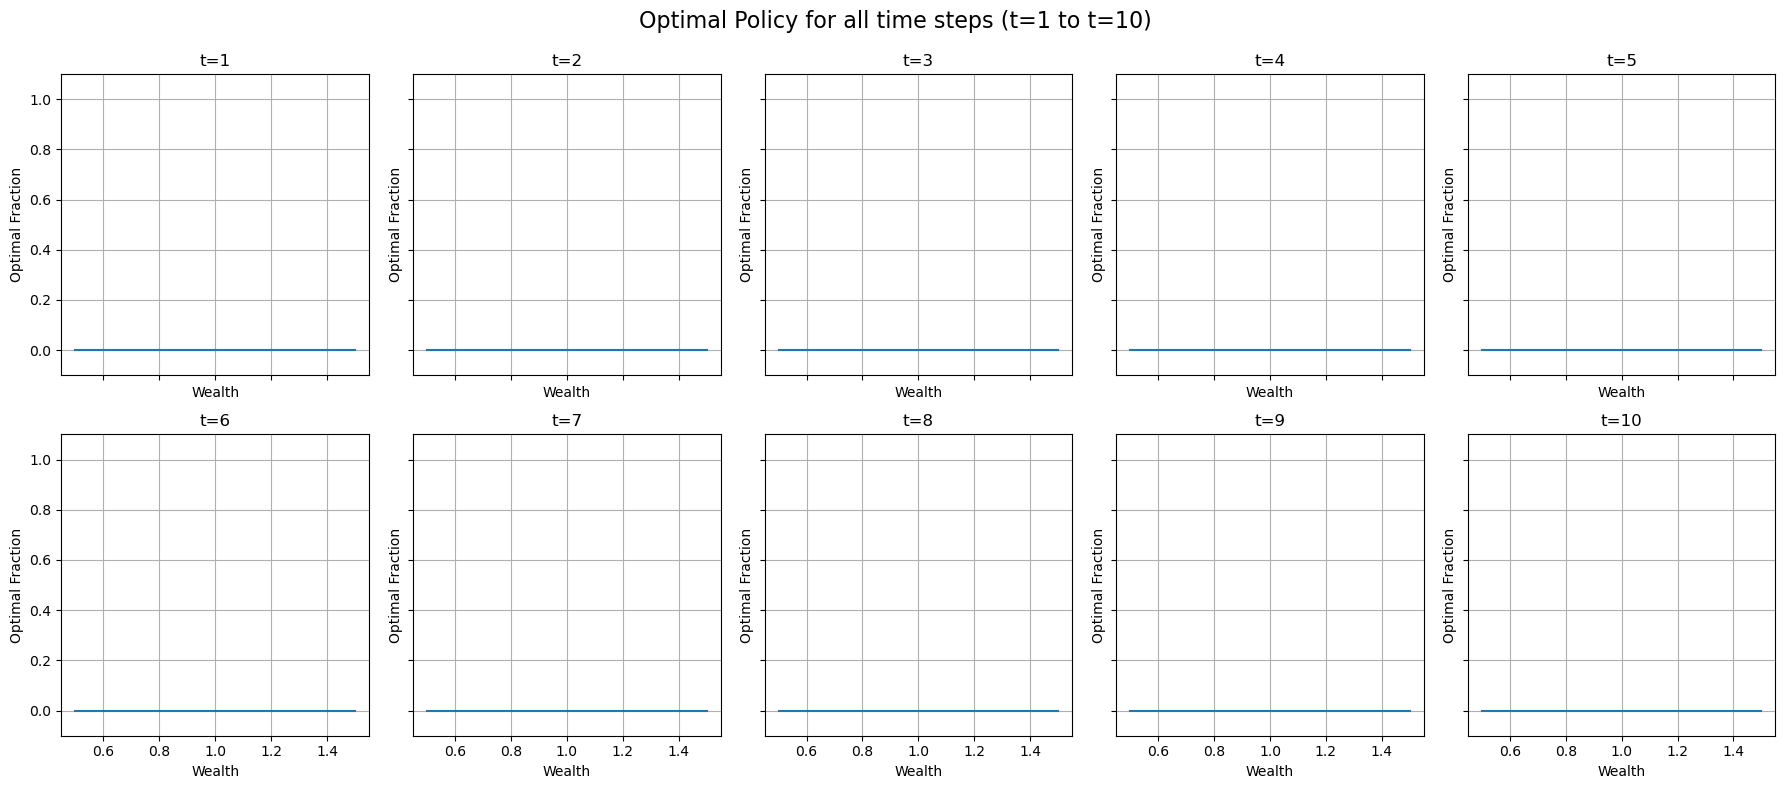

In [8]:
num_episodes = 1000000
env = DiscreteAssetAllocationEnv(
    max_steps=10,
    risk_free_rate=0.005,
    risky_up_prob=0.0,
    risky_up_rate=0.00,
    risky_down_rate=-0.01,
    risk_aversion=1.0,
    action_count=10
)

agent = DiscreteAssetAllocationAgent(
    env=env,
    epsilon_start=0.5,
    epsilon_end=0.01,
    epsilon_decay=1 / (num_episodes / 100),
    learning_rate_start=0.1,
    learning_rate_decay=1 / (num_episodes / 10),
    discount_factor=1.0
)

training(env, agent, num_episodes)
visualize_training_result(env, agent)

### Experiment 3

100%|██████████| 1000000/1000000 [05:36<00:00, 2975.53it/s]


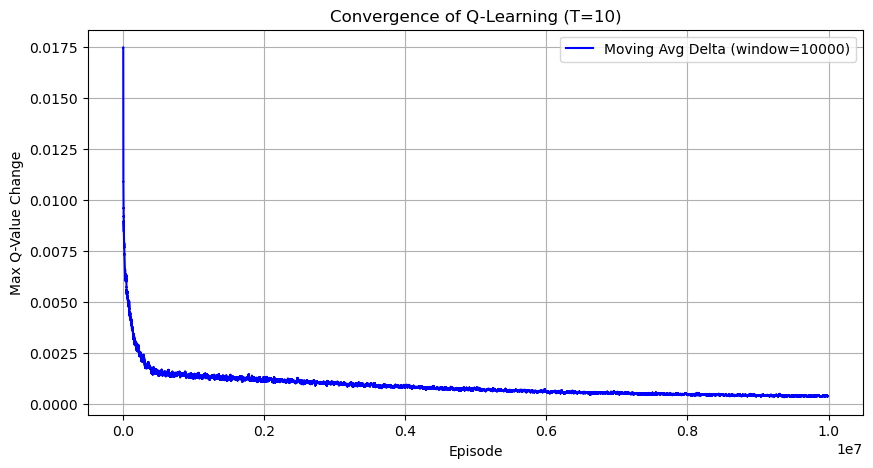

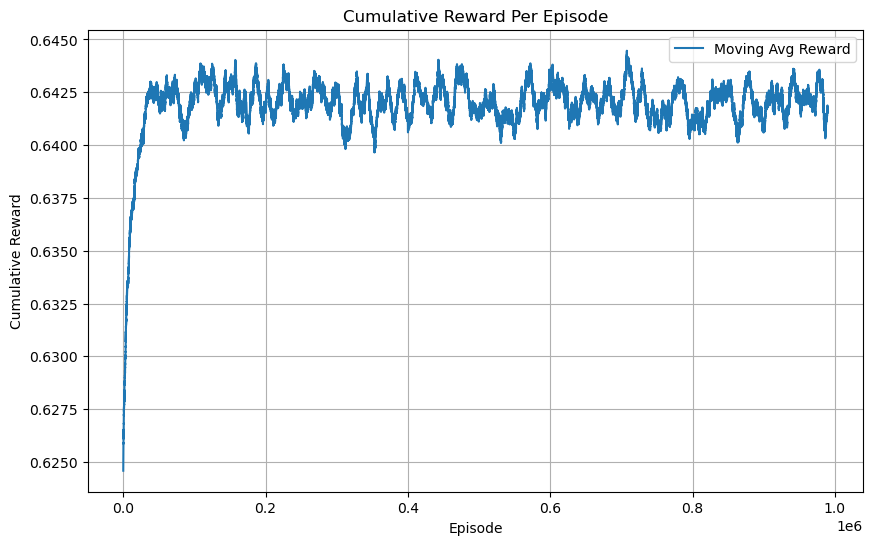

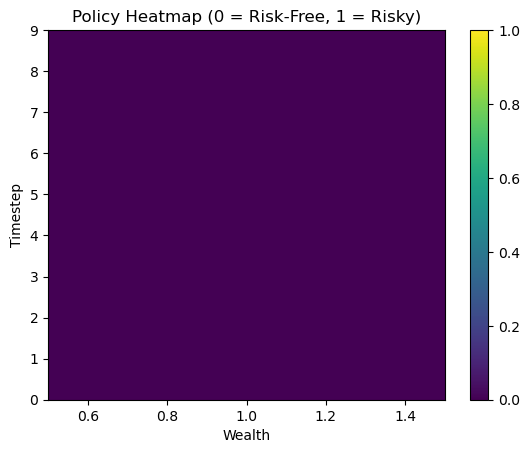

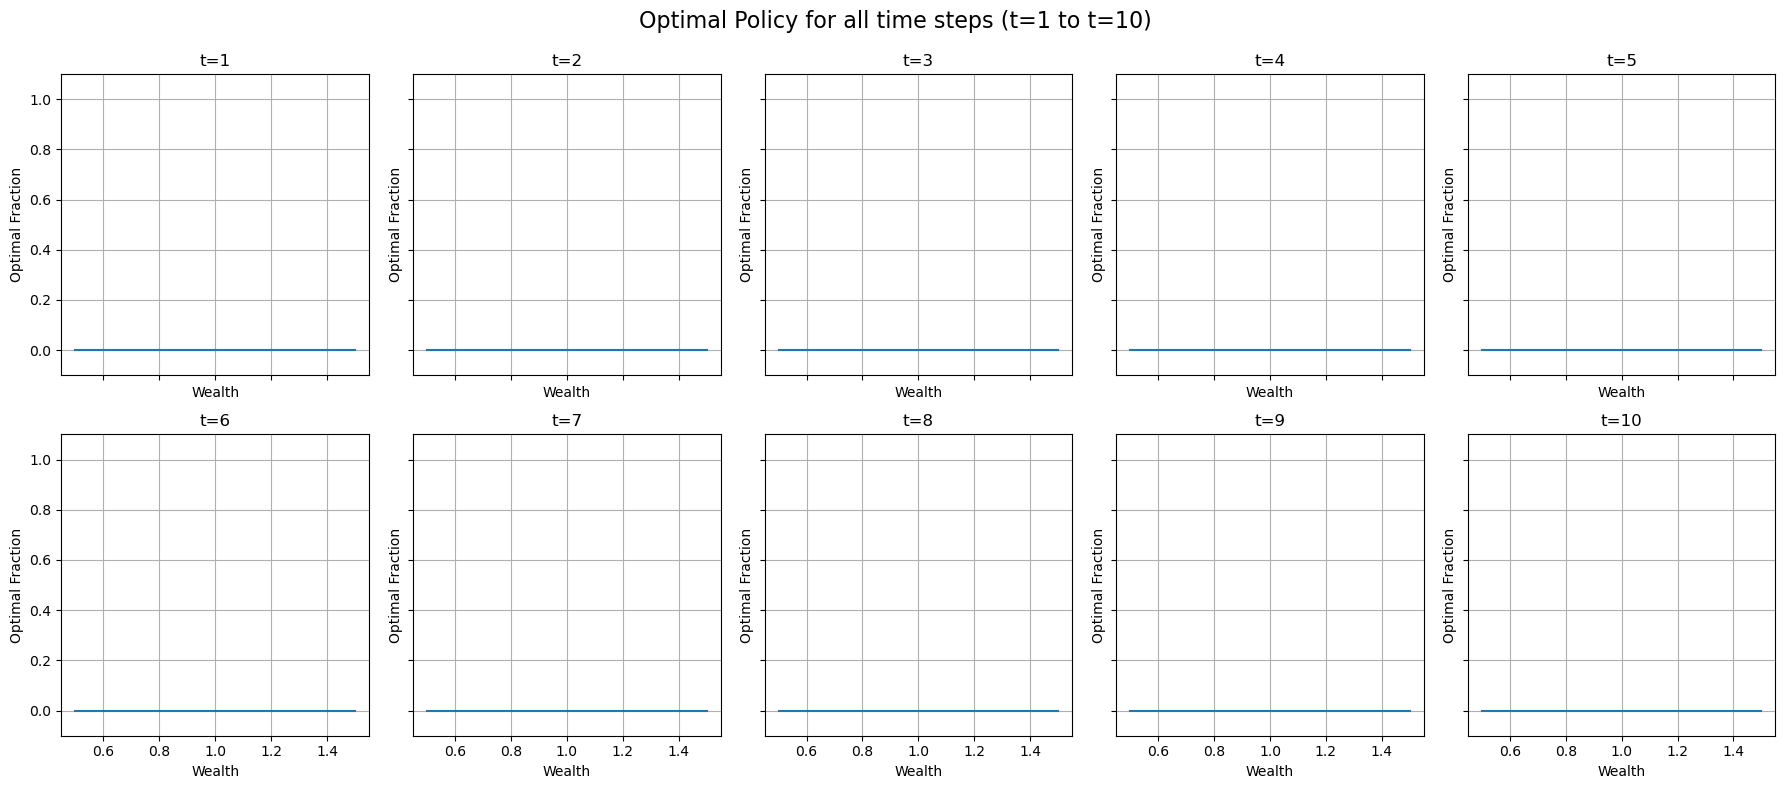

In [13]:
num_episodes = 1000000
env = DiscreteAssetAllocationEnv(
    max_steps=10,
    risk_free_rate=0.005,
    risky_up_prob=0.25,
    risky_up_rate=0.06,
    risky_down_rate=-0.05,
    risk_aversion=1.0,
    action_count=10
)

agent = DiscreteAssetAllocationAgent(
    env=env,
    epsilon_start=0.5,
    epsilon_end=0.01,
    epsilon_decay=1 / (num_episodes / 100),
    learning_rate_start=0.1,
    learning_rate_decay=1 / (num_episodes / 10),
    discount_factor=1.0
)

training(env, agent, num_episodes)
visualize_training_result(env, agent)